In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import procrustes
from scipy.signal import savgol_filter
from scipy.special import expit
from statsmodels.tsa.seasonal import STL
import imageio
import os

# Carica i dati
data = np.load(
    'data/0d890ad3184ded354855c291be64a07fe2e378fc/tensors/0d890ad3184ded354855c291be64a07fe2e378fc_serene_e2d1edf8-419c-45bf-8a59-0933c923e484.jpg_9_9_5_3.npy')

In [7]:

def decompose_signal(signal_1d, period=3):
    stl = STL(signal_1d, period=period, robust=True)
    result = stl.fit()
    return result.trend, result.seasonal, result.resid


In [8]:

# Applica la decomposizione a tutti i punti
components = {'trend': [], 'periodic': [], 'resid': []}

for i in range(data.shape[1]):
    point = data[:, i, :]  # (n_frames, 3)
    point_decomp = []
    for dim in range(3):
        trend, periodic, resid = decompose_signal(point[:, dim])
        point_decomp.append([trend, periodic, resid])
    trend_stack = np.stack([point_decomp[d][0] for d in range(3)], axis=1)
    periodic_stack = np.stack([point_decomp[d][1] for d in range(3)], axis=1)
    resid_stack = np.stack([point_decomp[d][2] for d in range(3)], axis=1)
    components['trend'].append(trend_stack)
    components['periodic'].append(periodic_stack)
    components['resid'].append(resid_stack)

for key in components:
    components[key] = np.stack(components[key], axis=1)

os.makedirs("gifs", exist_ok=True)

for key, comp_data in components.items():
    fig, ax = plt.subplots(figsize=(6, 6))
    scat = ax.scatter([], [], c=[], cmap='plasma', s=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()


    def init():
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array(np.array([]))
        return scat,


    def update(frame):
        points = comp_data[frame]
        scat.set_offsets(points[:, :2])
        scat.set_array(points[:, 2])
        ax.set_title(f"{key.capitalize()} - Frame {frame + 1}/{comp_data.shape[0]}")
        return scat,


    ani = animation.FuncAnimation(fig, update, frames=comp_data.shape[0], init_func=init, blit=True)
    ani.save(f"gifs/{key}.gif", writer='pillow', fps=15)
    plt.close()

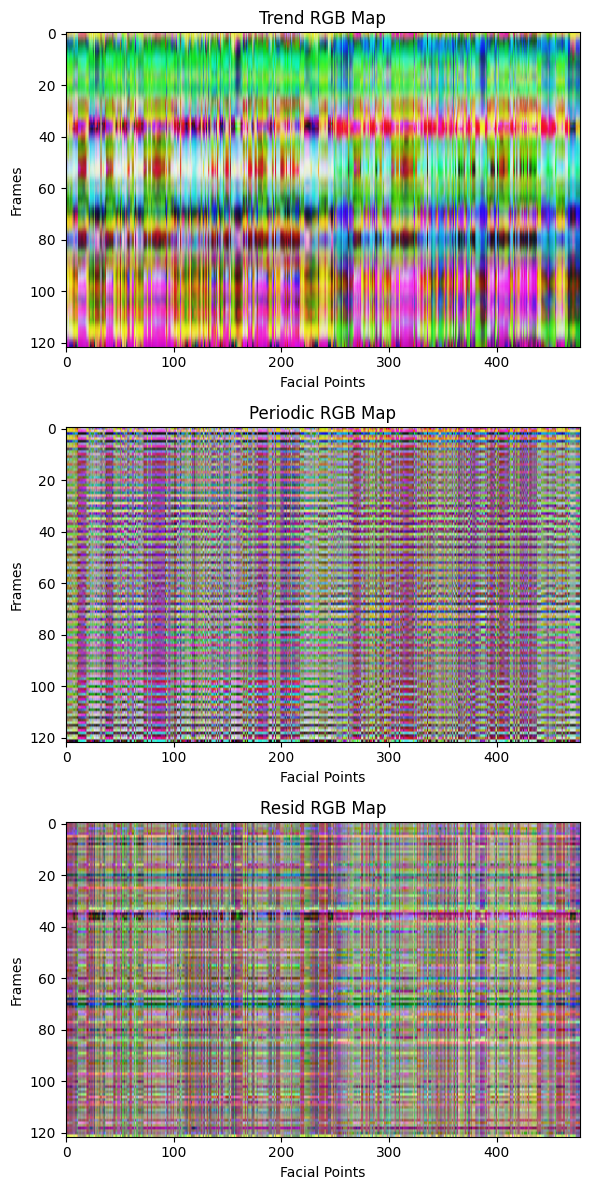

In [9]:


def encode_xyz_to_rgb(point_trajectory):
    pt_min = point_trajectory.min(axis=0)
    pt_max = point_trajectory.max(axis=0)
    normalized = (point_trajectory - pt_min) / (pt_max - pt_min + 1e-8)
    rgb_encoded = expit(6 * (normalized - 0.5))
    return rgb_encoded


rgb_maps = {}

for key, comp_data in components.items():
    rgb_encoded_per_point = []
    for i in range(comp_data.shape[1]):
        point_trajectory = comp_data[:, i, :]
        rgb = encode_xyz_to_rgb(point_trajectory)
        rgb_encoded_per_point.append(rgb)
    rgb_data = np.stack(rgb_encoded_per_point, axis=1)  # (n_frames, n_points, 3)
    rgb_image = (rgb_data * 255).astype(np.uint8)
    rgb_maps[key] = rgb_image

plt.figure(figsize=(6, 12))
for i, key in enumerate(['trend', 'periodic', 'resid']):
    plt.subplot(3, 1, i + 1)
    plt.imshow(rgb_maps[key], aspect='auto')
    plt.title(f"{key.capitalize()} RGB Map")
    plt.xlabel("Facial Points")
    plt.ylabel("Frames")

plt.tight_layout()
plt.show()

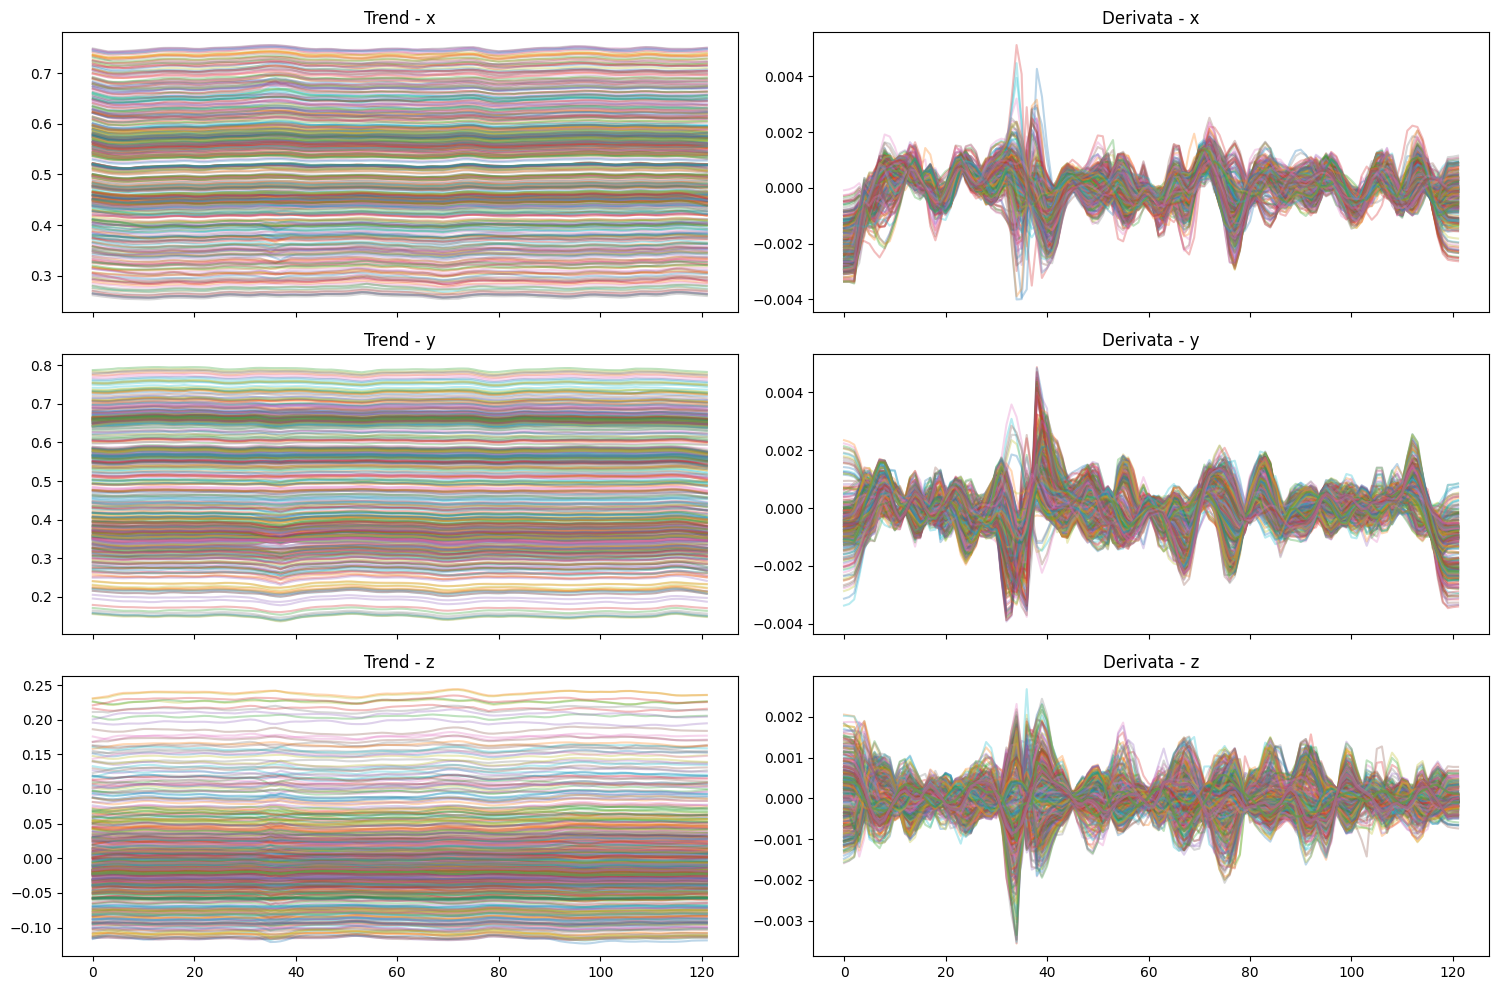

In [10]:

import scipy.fftpack as fftpack

trend = components['trend']  # shape (n_frames, n_points, 3)

fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
directions = ['x', 'y', 'z']

for i in range(3):
    signal = trend[:, :, i]  # shape (n_frames, n_points)
    derivative = np.gradient(signal, axis=0)

    axs[i, 0].plot(signal, alpha=0.3)
    axs[i, 0].set_title(f"Trend - {directions[i]}")
    axs[i, 1].plot(derivative, alpha=0.3)
    axs[i, 1].set_title(f"Derivata - {directions[i]}")

plt.tight_layout()
plt.show()